### Overview of this notebook

* motivating example with modular building blocks
    * connecting distances, aligners, classifiers
* pairwise transformers - the "type" of time series distances and kernels
* time series alignment and alignment distances, e.g., time warping
* composition patterns for distances, kernels, aligners
* outlook, roadmap, opportunities

In [1]:
import warnings

warnings.filterwarnings("ignore")

## 3.1 Motivating example

Rich component relationships between object types!

* many classifiers, regressors, clusterers use distances or kernels
* distances and kernels are often composite, e.g., sum-of-distance, independent distance
* TS distances are often based on scalar multivariate distances (e.g., Euclidean)
* TS distances are often based on alignment, TS aligners are an estimator type!
* aligners internally typically use scalar uni/multivariate distances

example:

* 1-nn using `sklearn` nearest neighbors
* with multivariate dynamic time warping distance, from `dtw-python` library 
* on multivariate `"mahalanobis"` distance from `scipy`
* in `sktime` compatible interface, constructed from custom components

so, conceptually:

* we build an sequence alignment algorithm (`dtw-python`) using `scipy` Mahalanobis dist
* we get the distance matrix computation from alignment algorithm
* we use that distance matrix in `sklearn` knn
* together this is a time series classifier!

In [2]:
from sktime.alignment.dtw_python import AlignerDTWfromDist
from sktime.classification.distance_based import KNeighborsTimeSeriesClassifier
from sktime.dists_kernels.compose_from_align import DistFromAligner
from sktime.dists_kernels.scipy_dist import ScipyDist

# Mahalanobis distance on R^n
mahalanobis_dist = ScipyDist(metric="mahalanobis")  # uses scipy distances

# pairwise multivariate aligner from dtw-python with Mahalanobis distance
mw_aligner = AlignerDTWfromDist(mahalanobis_dist)  # uses dtw-python

# turning this into alignment distance on time series
dtw_dist = DistFromAligner(mw_aligner)  # interface mutation to distance

# and using this distance in a k-nn classifier
clf = KNeighborsTimeSeriesClassifier(distance=dtw_dist)  # uses sklearn knn

In [3]:
clf.get_params()

{'algorithm': 'brute',
 'distance': DistFromAligner(aligner=AlignerDTWfromDist(dist_trafo=ScipyDist(metric='mahalanobis'))),
 'distance_mtype': None,
 'distance_params': None,
 'leaf_size': 30,
 'n_jobs': None,
 'n_neighbors': 1,
 'pass_train_distances': False,
 'weights': 'uniform',
 'distance__aligner': AlignerDTWfromDist(dist_trafo=ScipyDist(metric='mahalanobis')),
 'distance__aligner__dist_trafo': ScipyDist(metric='mahalanobis'),
 'distance__aligner__open_begin': False,
 'distance__aligner__open_end': False,
 'distance__aligner__step_pattern': 'symmetric2',
 'distance__aligner__window_type': 'none',
 'distance__aligner__dist_trafo__colalign': 'intersect',
 'distance__aligner__dist_trafo__metric': 'mahalanobis',
 'distance__aligner__dist_trafo__metric_kwargs': None,
 'distance__aligner__dist_trafo__p': 2,
 'distance__aligner__dist_trafo__var_weights': None}

what are all the objects in this chain?

* `ScipyDist` - pairwise distance between *scalars* - `transformer-pairwise` type
* `AlignerDtwFromDist` - time series alignment algorithm - `aligner` type
* `DistFromAligner`- pairwise distance between *time series* - `transformer-pairwise-panel` type
* `KNeighborsTimeSeriesClassifier` - time series classifier

In [4]:
from sktime.registry import scitype

scitype(mw_aligner)  # prints the type of estimator (as a string)
# same for other components

'aligner'

let's go through these - we've already seen classifiers.

## 3.2 Time series distances and kernels - pairwise panel transformers

### 3.2.1 Distances, kernels - general interface

pairwise panel transformers produce one distance per pair of series in the panel:

In [5]:
from sktime.datasets import load_osuleaf

# load an example time series panel in numpy mtype
X, _ = load_osuleaf(return_type="numpy3D")

X1 = X[:3]
X2 = X[5:10]

In [6]:
# constructing the transformer
from sktime.dists_kernels import FlatDist

# paired Euclidean distances, over time points
eucl_dist = FlatDist.create_test_instance()

In [7]:
X1.shape

(3, 1, 24)

In [8]:
X2.shape

(5, 1, 24)

X1 is panel with 3 series
X2 is panel with 5 series

so a matrix of pairwise distances from X1 to X2 should have shape (3, 5)

In [9]:
distmat = eucl_dist(X1, X2)

# alternatively, via the transform method
distmat = eucl_dist.transform(X1, X2)
distmat

array([[5.02485732, 3.59735482, 2.19102015, 2.21094109, 3.44785626],
       [5.03438946, 3.22205284, 1.32107749, 1.28227835, 2.10767238],
       [3.58874836, 6.69034981, 7.73977309, 7.70945353, 7.55532282]])

In [10]:
distmat.shape

(3, 5)

call or `transform` with a single arg is the same as passing twice:

In [11]:
distmat_symm = eucl_dist.transform(X1)
distmat_symm

array([[0.        , 2.21059984, 7.22653506],
       [2.21059984, 0.        , 7.31863575],
       [7.22653506, 7.31863575, 0.        ]])

pairwise panel transformers are `scikit-learn` / `scikit-base` interface compatible and composable, like everything else in `sktime`:

In [12]:
eucl_dist.get_params()

{'transformer': ScipyDist(),
 'transformer__colalign': 'intersect',
 'transformer__metric': 'euclidean',
 'transformer__metric_kwargs': None,
 'transformer__p': 2,
 'transformer__var_weights': None}

### 3.2.2 Time series distances, kernels - composition

pairwise transformers can be composed in a number of ways:

* arithmetics, e.g., addition, multiplication - use dunder `+`, `*` etc, or `CombinedDistance`
* subset to one or multiple columns - use `my_dist[colnames]` dunder
* sum or aggregate over univariate distance in multivariate panel, using `IndepDist` (also known as "independent distance")
* compose with series-to-series transformers - use `*` dunder or `make_pipeline`

In [13]:
from sktime.datasets import load_basic_motions

# load an example time series panel in numpy mtype
X, _ = load_basic_motions(return_type="numpy3D")
X = X[:3]
X.shape

(3, 6, 100)

In [14]:
# example 1: variable subsetting and arithmetic combinations

# first, euclidean distance as before
from sktime.dists_kernels import FlatDist

eucl_dist = FlatDist.create_test_instance()

# product of the distances on variables 2 and 5
prod_med_25 = eucl_dist[2] * eucl_dist[5]
prod_med_25

CombinedDistance(operation='*',
                 pw_trafos=[PwTrafoPanelPipeline(pw_trafo=FlatDist(transformer=ScipyDist()),
                                                 transformers=[ColumnSelect(columns=2)]),
                            PwTrafoPanelPipeline(pw_trafo=FlatDist(transformer=ScipyDist()),
                                                 transformers=[ColumnSelect(columns=5)])])

In [15]:
prod_med_25(X)

array([[ 0.        , 87.98179201, 32.72165827],
       [87.98179201,  0.        , 79.58756636],
       [32.72165827, 79.58756636,  0.        ]])

In [16]:
# example 2: independent dynamic time warping distance
from sktime.alignment.dtw_python import AlignerDTW
from sktime.dists_kernels.compose_from_align import DistFromAligner
from sktime.dists_kernels.indep import IndepDist

# dynamic time warping distance - this is multivariate
dtw_dist = DistFromAligner(AlignerDTW())

# independent distance - by default IndepDist sums over univariate distances
indep_dtw_dist = IndepDist(dtw_dist)

In [17]:
indep_dtw_dist(X)

array([[ 0.        , 31.7765985 , 32.65822   ],
       [31.7765985 ,  0.        , 39.78652033],
       [32.65822   , 39.78652033,  0.        ]])

In [18]:
# example 3: dynamic time warping distance on first differences
from sktime.transformations.series.difference import Differencer

diff_dtw_distance = Differencer() * dtw_dist

In [19]:
diff_dtw_distance(X)

array([[ 0.      , 20.622806, 27.731956],
       [20.622806,  0.      , 30.487498],
       [27.731956, 30.487498,  0.      ]])

some combinations may be available as efficient `numba` based distances.

E.g., difference-then-dtw is available as the "fixed" `sktime` native implementation
`DtwDist(derivative=True)` in `sktime.dists_kernels.dtw`.

### 3.3 pairwise tabular transformers

### 3.3.1 pairwise tabular transformers - general interface

pairwise tabular transformers transform pairs of ordinary tabular data, e.g., plain `pd.DataFrame`

produce one distance per pair of rows

In [20]:
from sktime.datatypes import get_examples

# we retrieve some DataFrame examples
X_tabular = get_examples("pd.DataFrame", "Series")[1]
X2_tabular = get_examples("pd.DataFrame", "Series")[1][0:3]

In [21]:
# just an ordinary DataFrame, no time series
X_tabular

,a,b
0,1.0,3.000000
1,4.0,7.000000
2,0.5,2.000000
3,-3.0,-0.428571


In [22]:
X2_tabular

,a,b
0,1.0,3.0
1,4.0,7.0
2,0.5,2.0


example: pairwise Euclidean distance between rows

In [23]:
# constructing the transformer
from sktime.dists_kernels import ScipyDist

# mean of paired Euclidean distances
my_tabular_dist = ScipyDist(metric="euclidean")

In [24]:
# obtain matrix of distances between each pair of rows in X_tabular, X2_tabular
my_tabular_dist(X_tabular, X2_tabular)

array([[ 0.        ,  5.        ,  1.11803399],
       [ 5.        ,  0.        ,  6.10327781],
       [ 1.11803399,  6.10327781,  0.        ],
       [ 5.26831112, 10.20704039,  4.26004216]])

In [25]:
# alternative call with transform:
my_tabular_dist.transform(X_tabular, X2_tabular)

array([[ 0.        ,  5.        ,  1.11803399],
       [ 5.        ,  0.        ,  6.10327781],
       [ 1.11803399,  6.10327781,  0.        ],
       [ 5.26831112, 10.20704039,  4.26004216]])

In [26]:
# as with pairwise panel transformers, one arg means second is the same
my_tabular_dist(X_tabular)

array([[ 0.        ,  5.        ,  1.11803399,  5.26831112],
       [ 5.        ,  0.        ,  6.10327781, 10.20704039],
       [ 1.11803399,  6.10327781,  0.        ,  4.26004216],
       [ 5.26831112, 10.20704039,  4.26004216,  0.        ]])

### 3.3.2 constructing pairwise time series transformers from tabular ones

"simple" time series distances can be obtained directly from tabular transformers:

* flattening the time series to tabular, and then computing the distance - `FlatDist`
* aggregating the tabular distance matrix, from two individual time series - `AggrDist`

these are important "baseline" distances!

Both can be used on `sktime` pairwise transformers and `sklearn` pairwise transformers.

the classes are called "dist" but all apply to kernels.

In [27]:
from sktime.datasets import load_basic_motions

# load an example time series panel in numpy mtype
X, _ = load_basic_motions(return_type="numpy3D")
X = X[:3]
X.shape

(3, 6, 100)

In [28]:
# example 1: flat Gaussian RBF kernel between time series
from sklearn.gaussian_process.kernels import RBF
from sktime.dists_kernels import FlatDist

flat_gaussian_tskernel = FlatDist(RBF(length_scale=10))
flat_gaussian_tskernel.get_params()

{'transformer': RBF(length_scale=10),
 'transformer__length_scale': 10,
 'transformer__length_scale_bounds': (1e-05, 100000.0)}

In [29]:
flat_gaussian_tskernel(X)

array([[1.        , 0.02267939, 0.28034066],
       [0.02267939, 1.        , 0.05447445],
       [0.28034066, 0.05447445, 1.        ]])

In [30]:
# example 2: pairwise cosine distance - we've already seen FlatDist a couple times
from sktime.dists_kernels import FlatDist, ScipyDist

mean_cos_tsdist = FlatDist(ScipyDist(metric="cosine"))
mean_cos_tsdist.get_params()

{'transformer': ScipyDist(metric='cosine'),
 'transformer__colalign': 'intersect',
 'transformer__metric': 'cosine',
 'transformer__metric_kwargs': None,
 'transformer__p': 2,
 'transformer__var_weights': None}

In [31]:
mean_cos_tsdist(X)

array([[1.11022302e-16, 1.36699314e+00, 6.99338545e-01],
       [1.36699314e+00, 0.00000000e+00, 1.10061843e+00],
       [6.99338545e-01, 1.10061843e+00, 0.00000000e+00]])

## 3.4 alignment algorithms, aka aligners

* "aligners" find a new index set for 2 or more time series so they become "similar"
* new index set being a non-linear reparameterization of the old index sets
* often, aligners also produce an overall distance between the two series

### 3.4.1 aligners - general interface

aligner methods:

* `fit` - computes alignment
* `get_alignment` - returns reparametrized indices, also called "alignment path"
* `get_aligned` returns reparametrized series
* `get_distance` returns distance between the two aligned series - only available if `"capability:get_distance"`

let's try to align two leaves from osuleaf!

In [32]:
from sktime.datasets import load_osuleaf

# load an example time series panel in numpy mtype
X, _ = load_osuleaf(return_type="pd-multiindex")

X1 = X.loc[0]  # leaf 0
X2 = X.loc[1]  # leaf 1

(<Figure size 1600x400 with 1 Axes>, <Axes: >)

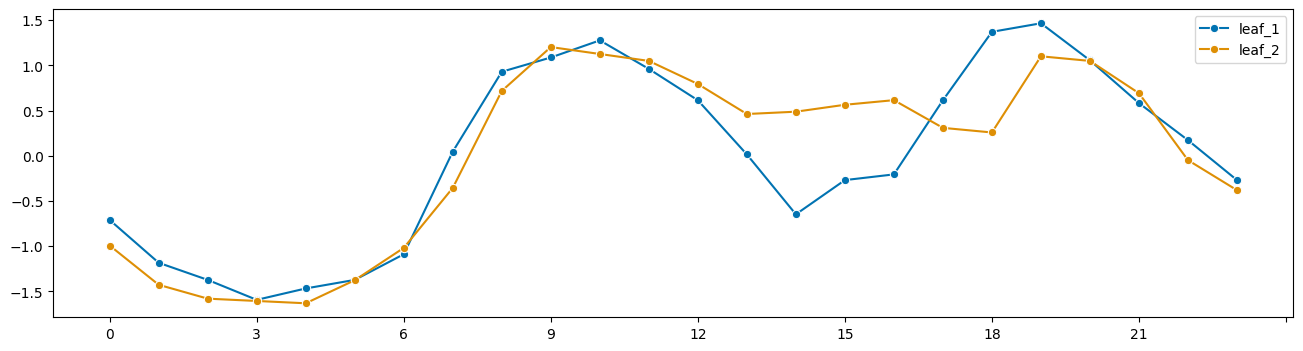

In [33]:
from sktime.utils.plotting import plot_series

plot_series(X1, X2, labels=["leaf_1", "leaf_2"])

In [34]:
from sktime.alignment.dtw_python import AlignerDTW

# use dtw-python package for aligning
# simple univariate alignment algorithm with default params
aligner = AlignerDTW()

In [35]:
aligner.fit([X1, X2])  # series to align need to be passed as list

AlignerDTW()

In [36]:
# alignment path
aligner.get_alignment()

# this aligns, e.g.:
# from row "2": aligns index 0 in X1 with index 2 of X2
# from row "664": aligns index 424 in X1 with index 423 of X2

,ind0,ind1
0,0,0
1,1,0
2,2,1
3,3,2
4,3,3
5,3,4
6,4,4
7,5,5
8,6,6
9,7,7


In [37]:
# obtain the aligned versions of the two series
X1_al, X2_al = aligner.get_aligned()

(<Figure size 1600x400 with 1 Axes>, <Axes: >)

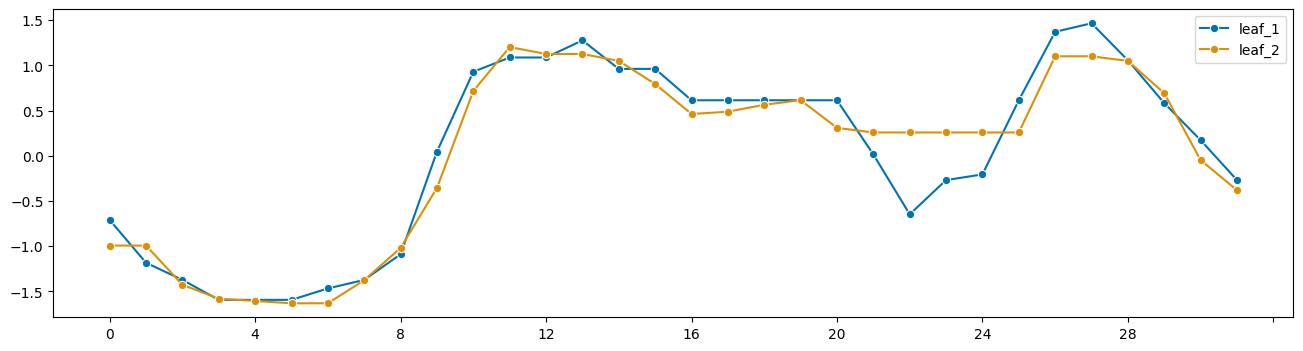

In [38]:
from sktime.utils.plotting import plot_series

plot_series(X1_al.reset_index(drop=True), X2_al.reset_index(drop=True), labels=["leaf_1", "leaf_2"])

the DTW aligner has a "distance" implemented

intuitively, it is a distance that sums distance after aligning, and the amount of stretch:

In [39]:
# the AlignerDTW class (based on dtw-python) doesn't just align, it also produces a distance
aligner.get_tags()

{'python_dependencies_alias': {'dtw-python': 'dtw'},
 'capability:multiple-alignment': False,
 'capability:distance': True,
 'capability:distance-matrix': True,
 'python_dependencies': 'dtw-python'}

In [40]:
# this is the distance between the two time series we aligned
aligner.get_distance()

8.282734981999997

### 3.4.2 alignment based time series distances

the `DistFromAligner` wrapper simply computes distance per pair of aligned series.

This turns any aligner into a time series distance:

In [41]:
from sktime.alignment.dtw_python import AlignerDTW
from sktime.dists_kernels.compose_from_align import DistFromAligner

# dynamic time warping distance - this is multivariate
dtw_dist = DistFromAligner(AlignerDTW())

In [42]:
from sktime.datasets import load_osuleaf

# load an example time series panel in numpy mtype
X, _ = load_osuleaf(return_type="numpy3D")

X1 = X[:3]
X2 = X[5:10]

In [43]:
dtw_distmat = dtw_dist(X1, X2)
dtw_distmat

array([[16.20666729, 11.08114716,  8.01728107,  7.76310399,  9.50661536],
       [20.07092178, 12.38841529,  4.9980687 ,  5.38099438,  6.58028528],
       [ 9.69803841, 22.01021323, 27.38894568, 29.73167835, 27.20667031]])

In [44]:
dtw_distmat.shape

(3, 5)

## 3.5 revisiting the initial example

In [45]:
from sktime.alignment.dtw_python import AlignerDTWfromDist
from sktime.classification.distance_based import KNeighborsTimeSeriesClassifier
from sktime.dists_kernels.compose_from_align import DistFromAligner
from sktime.dists_kernels.scipy_dist import ScipyDist

# Mahalanobis distance on R^n
mahalanobis_dist = ScipyDist(metric="mahalanobis")  # uses scipy distances

# pairwise multivariate aligner from dtw-python with Mahalanobis distance
mw_aligner = AlignerDTWfromDist(mahalanobis_dist)  # uses dtw-python

# turning this into alignment distance on time series
dtw_dist = DistFromAligner(mw_aligner)  # interface mutation to distance

# and using this distance in a k-nn classifier
clf = KNeighborsTimeSeriesClassifier(distance=dtw_dist)  # uses sklearn knn

In [46]:
clf

KNeighborsTimeSeriesClassifier(distance=DistFromAligner(aligner=AlignerDTWfromDist(dist_trafo=ScipyDist(metric='mahalanobis'))))

* we build an sequence alignment algorithm (`dtw-python`) using `scipy` Mahalanobis dist
* we get the distance matrix computation from alignment algorithm
* we use that distance matrix in `sklearn` knn
* together this is a time series classifier!

## 3.6 Searching for distances, kernels, transformers

As with all `sktime` objects, we can use the `registry.all_estimators` utility to display all transformers in `sktime`.

The relevant scitypes are:

* `"transformer-pairwise"` for all pairwise transformers on tabular data
* `"transformer-panel"` for all pairwise transformers on panel data
* `"aligner"` for all time series aligners
* `"transformer"` for all transformers, these can be composed with all the aboev

In [47]:
from sktime.registry import all_estimators

In [48]:
# listing all pairwise panel transformers - distances, kernels on time series
all_estimators("transformer-pairwise-panel", as_dataframe=True)

,name,object
0,AggrDist,<class 'sktime.dists_kernels.compose_tab_to_pa...
1,CombinedDistance,<class 'sktime.dists_kernels.algebra.CombinedD...
2,ConstantPwTrafoPanel,<class 'sktime.dists_kernels.dummy.ConstantPwT...
3,DistFromAligner,<class 'sktime.dists_kernels.compose_from_alig...
4,DistFromKernel,<class 'sktime.dists_kernels.dist_to_kern.Dist...
5,DtwDist,<class 'sktime.dists_kernels.dtw.DtwDist'>
6,EditDist,<class 'sktime.dists_kernels.edit_dist.EditDist'>
7,FlatDist,<class 'sktime.dists_kernels.compose_tab_to_pa...
8,IndepDist,<class 'sktime.dists_kernels.indep.IndepDist'>
9,KernelFromDist,<class 'sktime.dists_kernels.dist_to_kern.Kern...


In [49]:
# listing all pairwise (tabular) transformers - distances, kernels on vectors/df-rows
all_estimators("transformer-pairwise", as_dataframe=True)

,name,object
0,ScipyDist,<class 'sktime.dists_kernels.scipy_dist.ScipyD...


In [50]:
# listing all alignment algorithms that can produce distances
all_estimators("aligner", as_dataframe=True, filter_tags={"capability:distance": True})

,name,object
0,AlignerDTW,<class 'sktime.alignment.dtw_python.AlignerDTW'>
1,AlignerDTWfromDist,<class 'sktime.alignment.dtw_python.AlignerDTW...
2,AlignerDtwNumba,<class 'sktime.alignment.dtw_numba.AlignerDtwN...


## 3.7 Outlook, roadmap

* implementing estimators - distances, classifiers, etc
* backend optimizations - `numba`, distributed/parallel
* sequence-to-sequence regression, classification
* further maturing the time series alignment module

join and contribute!

## 3.8 Summary

* `sktime` - modular framework for learning with time series
* panel data = collections of time series - tasks classification, regression, clustering
* build flexible pipelines with transformers, tune via grid search etc
* panel estimators typically rely on time series distances, kernels, aligners
* TS distances, kernels, aligners can also be constructed in modular, flexible way
* all objects above are first-class citiziens with `sklearn`-like interface!